<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">

# Aprendizaje por Refuerzo II - Desafío Práctico
- Alumno: Agustín Antonio López Fredes

## Descripción
En este trabajo se realiza una comparación experimental entre tres algoritmos de Deep Reinforcement Learning ampliamente utilizados:
- A2C (Advantage Actor-Critic)
- PPO (Proximal Policy Optimization)
- SAC (Soft Actor-Critic)

El objetivo es analizar su desempeño en el entorno continuo BipedalWalker-v3 de la biblioteca Gymnasium, donde un agente controla un bípedo que debe aprender a caminar sobre un terreno irregular optimizando su equilibrio y desplazamiento.

## Objetivo
- Evaluar la capacidad de aprendizaje y estabilidad de cada algoritmo en un entorno continuo.
- Comparar la velocidad de convergencia y la recompensa promedio final.
- Observar el comportamiento del agente entrenado (mediante videos de simulación).

## Características del entorno
- Tipo: continuo
- Observaciones: vector de 24 variables (posición, velocidad, ángulos articulares, etc.)
- Acciones: vector continuo de 4 valores (fuerzas aplicadas en las articulaciones)
- Recompensa: proporcional a la distancia recorrida y penalizaciones por caídas o movimientos ineficientes
- Objetivo: recorrer la mayor distancia posible sin caer

## Metodología
Cada algoritmo se entrenó por 3 millones de pasos de tiempo (timesteps) utilizando la implementación de Stable Baselines3.

Los resultados se registraron mediante callbacks de evaluación periódica y se analizaron los archivos de log para graficar la evolución de las recompensas y comparar el rendimiento de los tres modelos.

In [16]:
import gymnasium as gym
from stable_baselines3 import A2C, PPO, SAC
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import EvalCallback, StopTrainingOnNoModelImprovement
import matplotlib.pyplot as plt
from stable_baselines3.common.logger import configure
import pandas as pd
import numpy as np
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
import os

# Crear carpetas
os.makedirs("./models", exist_ok=True)
os.makedirs("./logs", exist_ok=True)

reentrenar = False  # Cambiar a True para forzar nuevo entrenamiento
total_timesteps = 300_000 #Se subió desde 300_000

## A2C (Advantage Actor-Critic)
A2C es un método actor-crítico síncrono que combina dos redes neuronales:
- un actor, que aprende una política π(a|s) para seleccionar acciones, y
- un crítico, que estima el valor del estado V(s).

La política se actualiza en función de la ventaja estimada:

$ A(s, a) = Q(s, a) - V(s) $

Esto reduce la varianza del gradiente y estabiliza el entrenamiento respecto a los métodos puramente basados en recompensas.
A2C es on-policy, es decir, aprende solo a partir de experiencias generadas por la política actual.
Es eficiente en entornos discretos, aunque puede volverse inestable en espacios continuos de alta dimensión.

In [ ]:
# ===============================
# CONFIGURACIÓN DE DIRECTORIOS
# ===============================
model_dir = "./models/a2c/"
log_dir = "./logs/a2c/"
tensorboard_dir = "./a2c_tensorboard/"
os.makedirs(model_dir, exist_ok=True)
os.makedirs(log_dir, exist_ok=True)

best_model_path = os.path.join(model_dir, "best_model.zip")
vecnorm_path = os.path.join(model_dir, "vecnormalize.pkl")

# ===============================
# CREACIÓN DE ENTORNOS
# ===============================
def make_env():
    env = gym.make("BipedalWalker-v3")
    env = Monitor(env, filename=os.path.join(log_dir, "monitor.csv"))
    return env

train_env = DummyVecEnv([make_env])
train_env = VecNormalize(train_env, norm_obs=True, norm_reward=False, clip_obs=10.0)

eval_env = DummyVecEnv([make_env])
eval_env = VecNormalize(eval_env, norm_obs=True, norm_reward=False, clip_obs=10.0)

# ===============================
# CALLBACK DE EVALUACIÓN + EARLY STOPPING
# ===============================
stop_callback = StopTrainingOnNoModelImprovement(
    max_no_improvement_evals=10,  # detener si no mejora en 10 evaluaciones seguidas
    min_evals=5,                  # esperar al menos 5 antes de considerar parar
    verbose=1
)

eval_callback = EvalCallback(
    eval_env,
    best_model_save_path=model_dir,
    log_path=log_dir,
    eval_freq=10_000,
    deterministic=True,
    callback_after_eval=stop_callback
)


# ===============================
# ENTRENAMIENTO O CARGA DEL MODELO
# ===============================
if reentrenar or not os.path.exists(best_model_path):
    print("Entrenando nuevo modelo A2C optimizado...")

    policy_kwargs = dict(net_arch=[dict(pi=[256, 256], vf=[256, 256])])

    model = A2C(
        "MlpPolicy",
        train_env,
        verbose=1,
        learning_rate=3e-5,
        gamma=0.99,
        gae_lambda=0.95,
        n_steps=5,                # tamaño de batch típico en A2C
        ent_coef=0.01,
        policy_kwargs=policy_kwargs,
        tensorboard_log=tensorboard_dir,
    )

    new_logger = configure(log_dir, ["stdout", "csv", "tensorboard"])
    model.set_logger(new_logger)

    model.learn(total_timesteps=total_timesteps, callback=eval_callback)

    model.save(best_model_path)
    train_env.save(vecnorm_path)
    print(f"Modelo y normalizador guardados en {model_dir}")

else:
    print("Modelo A2C ya existe. Cargando...")
    model = A2C.load(best_model_path)

    if os.path.exists(vecnorm_path):
        train_env = VecNormalize.load(vecnorm_path, train_env)
        train_env.training = False
        train_env.norm_reward = False
        print("VecNormalize cargado correctamente.")
    else:
        print("Advertencia: no se encontró vecnormalize.pkl. Se usará entorno sin normalización.")

# ===============================
# GRAFICAR RECOMPENSAS DE EVALUACIÓN
# ===============================
eval_file_npz = os.path.join(log_dir, "evaluations.npz")

if os.path.exists(eval_file_npz):
    data = np.load(eval_file_npz)
    timesteps = data["timesteps"]
    results = data["results"]

    mean_rewards = results.mean(axis=1)
    std_rewards = results.std(axis=1)

    plt.plot(timesteps, mean_rewards, label="Recompensa media")
    plt.fill_between(
        timesteps,
        mean_rewards - std_rewards,
        mean_rewards + std_rewards,
        alpha=0.2,
        label="Desvío estándar",
    )
    plt.xlabel("Timesteps")
    plt.ylabel("Recompensa media")
    plt.title("Evolución A2C - BipedalWalker-v3 (Optimizado)")
    plt.legend()
    plt.show()
else:
    print("No se encontró evaluations.npz — el callback puede no haber guardado evaluaciones.")

# ===============================
# MOSTRAR ÚLTIMAS MÉTRICAS DEL LOGGER CSV
# ===============================
csv_file = os.path.join(log_dir, "progress.csv")
if os.path.exists(csv_file):
    df = pd.read_csv(csv_file)
    print("\nÚltimas métricas registradas:")
    display(df.tail(5)[["time/total_timesteps", "rollout/ep_rew_mean", "rollout/ep_len_mean"]])
else:
    print("No se encontró progress.csv — puede que el logger CSV no haya sido inicializado aún.")

# ===============================
# EVALUAR EL MODELO EN EL ENTORNO
# ===============================
obs = train_env.reset()
for step in range(1500):
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, info = train_env.step(action)
    train_env.render()
train_env.close()

Entrenando nuevo modelo A2C optimizado...
Using cuda device
Logging to ./logs/a2c/


/home/agustin/Desktop/CEIA UBA/Aprendizaje por Refuerzo II/CEIA-AprendizajeRefuerzoII/.venv/lib/python3.12/site-packages/stable_baselines3/common/policies.py:486: UserWarning: As shared layers in the mlp_extractor are removed since SB3 v1.8.0, you should now pass directly a dictionary and not a list (net_arch=dict(pi=..., vf=...) instead of net_arch=[dict(pi=..., vf=...)])
  warnings.warn(
/home/agustin/Desktop/CEIA UBA/Aprendizaje por Refuerzo II/CEIA-AprendizajeRefuerzoII/.venv/lib/python3.12/site-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run A2C on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training mi

TypeError: bad operand type for unary -: 'NoneType'

## PPO (Proximal Policy Optimization)
PPO mejora A2C al restringir la magnitud de los cambios en la política entre actualizaciones sucesivas.
Introduce una función de pérdida con “clipping” que evita actualizaciones demasiado grandes:

$ L^{CLIP}(\theta) = \mathbb{E}_t [ \min( r_t(\theta) \hat{A}_t , \text{clip}(r_t(\theta), 1 - \epsilon, 1 + \epsilon) \hat{A}_t ) ] $

donde
$ r_t(\theta) = \frac{\pi_\theta(a_t|s_t)}{\pi_{\text{old}}(a_t|s_t)} $
es el ratio de probabilidad entre la política nueva y la anterior.

Este enfoque mejora la estabilidad y robustez del entrenamiento, siendo uno de los algoritmos más utilizados en RL moderno.

In [ ]:
# ===============================
# PARÁMETROS GENERALES
# ===============================


# ===============================
# CONFIGURACIÓN DE DIRECTORIOS
# ===============================
model_dir = "./models/ppo/"
log_dir = "./logs/ppo/"
tensorboard_dir = "./ppo_tensorboard/"
os.makedirs(model_dir, exist_ok=True)
os.makedirs(log_dir, exist_ok=True)

best_model_path = os.path.join(model_dir, "best_model.zip")
vecnorm_path = os.path.join(model_dir, "vecnormalize.pkl")

# ===============================
# CREACIÓN DE ENTORNOS
# ===============================
def make_env():
    env = gym.make("BipedalWalker-v3")
    env = Monitor(env, filename=os.path.join(log_dir, "monitor.csv"))
    return env

train_env = DummyVecEnv([make_env])
train_env = VecNormalize(train_env, norm_obs=True, norm_reward=False, clip_obs=10.0)

eval_env = DummyVecEnv([make_env])
eval_env = VecNormalize(eval_env, norm_obs=True, norm_reward=False, clip_obs=10.0)

# ===============================
# CALLBACK DE EVALUACIÓN + EARLY STOPPING
# ===============================
stop_callback = StopTrainingOnNoModelImprovement(
    max_no_improvement_evals=10,  # detener si no mejora en 10 evaluaciones consecutivas
    min_evals=5,                  # esperar al menos 5 antes de considerar parar
    verbose=1
)

eval_callback = EvalCallback(
    eval_env,
    best_model_save_path=model_dir,
    log_path=log_dir,
    eval_freq=10_000,             # cada 10k pasos
    deterministic=True,
    callback_after_eval=stop_callback
)


# ===============================
# ENTRENAMIENTO O CARGA DEL MODELO
# ===============================
if reentrenar or not os.path.exists(best_model_path):
    print("Entrenando nuevo modelo PPO optimizado...")

    policy_kwargs = dict(net_arch=[dict(pi=[256, 256], vf=[256, 256])])

    model = PPO(
        "MlpPolicy",
        train_env,
        verbose=1,
        learning_rate=3e-5,
        gamma=0.99,
        gae_lambda=0.95,
        n_steps=2048,
        ent_coef=0.01,
        clip_range=0.2,
        policy_kwargs=policy_kwargs,
        tensorboard_log=tensorboard_dir,
    )

    new_logger = configure(log_dir, ["stdout", "csv", "tensorboard"])
    model.set_logger(new_logger)

    model.learn(total_timesteps=total_timesteps, callback=eval_callback)

    model.save(best_model_path)
    train_env.save(vecnorm_path)
    print(f"Modelo y normalizador guardados en {model_dir}")

else:
    print("Modelo PPO ya existe. Cargando...")
    model = PPO.load(best_model_path)

    if os.path.exists(vecnorm_path):
        train_env = VecNormalize.load(vecnorm_path, train_env)
        train_env.training = False
        train_env.norm_reward = False
        print("VecNormalize cargado correctamente.")
    else:
        print("Advertencia: no se encontró vecnormalize.pkl. Se usará entorno sin normalización.")

# ===============================
# GRAFICAR RECOMPENSAS DE EVALUACIÓN
# ===============================
eval_file_npz = os.path.join(log_dir, "evaluations.npz")

if os.path.exists(eval_file_npz):
    data = np.load(eval_file_npz)
    timesteps = data["timesteps"]
    results = data["results"]
    mean_rewards = results.mean(axis=1)
    std_rewards = results.std(axis=1)

    plt.plot(timesteps, mean_rewards, label="Recompensa media")
    plt.fill_between(
        timesteps,
        mean_rewards - std_rewards,
        mean_rewards + std_rewards,
        alpha=0.2,
        label="Desvío estándar",
    )
    plt.xlabel("Timesteps")
    plt.ylabel("Recompensa media")
    plt.title("Evolución PPO - BipedalWalker-v3 (Optimizado)")
    plt.legend()
    plt.show()
else:
    print("No se encontró evaluations.npz — puede que el callback no haya guardado evaluaciones.")

# ===============================
# MOSTRAR ÚLTIMAS MÉTRICAS DEL LOGGER CSV
# ===============================
csv_file = os.path.join(log_dir, "progress.csv")
if os.path.exists(csv_file):
    df = pd.read_csv(csv_file)
    print("\nÚltimas métricas registradas:")
    display(df.tail(5)[["time/total_timesteps", "rollout/ep_rew_mean", "rollout/ep_len_mean"]])
else:
    print("No se encontró progress.csv — puede que el logger CSV no haya sido inicializado aún.")

# ===============================
# EVALUAR EL MODELO EN EL ENTORNO
# ===============================
obs = train_env.reset()
for step in range(1500):
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, info = train_env.step(action)
    train_env.render()
train_env.close()

Modelo PPO ya existe. Cargando...
VecNormalize cargado correctamente.
No se encontró evaluations.npz — puede que el callback no haya guardado evaluaciones.
No se encontró progress.csv — puede que el logger CSV no haya sido inicializado aún.


/home/agustin/Desktop/CEIA UBA/Aprendizaje por Refuerzo II/CEIA-AprendizajeRefuerzoII/.venv/lib/python3.12/site-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


## SAC (Soft Actor-Critic)
SAC es un algoritmo off-policy actor-crítico que combina aprendizaje de valor y política estocástica bajo el principio de entropía máxima.
En lugar de optimizar solo la recompensa esperada, maximiza también la entropía de la política:

$J(\pi) = \mathbb{E}_{(s_t, a_t) \sim \rho_\pi} [ r(s_t, a_t) + \alpha \, \mathcal{H}(\pi(\cdot|s_t)) ] $

El término de entropía $\mathcal{H}$ incentiva exploración, evitando que la política se vuelva determinista prematuramente.

El parámetro $\alpha$ regula el equilibrio entre exploración y explotación, y puede ajustarse automáticamente durante el entrenamiento.
SAC es especialmente eficaz en entornos continuos, logrando alta estabilidad y convergencia rápida.

In [ ]:
# ===============================
# CONFIGURACIÓN DE DIRECTORIOS
# ===============================
model_dir = "./models/sac/"
log_dir = "./logs/sac/"
tensorboard_dir = "./sac_tensorboard/"
os.makedirs(model_dir, exist_ok=True)
os.makedirs(log_dir, exist_ok=True)

best_model_path = os.path.join(model_dir, "best_model.zip")
vecnorm_path = os.path.join(model_dir, "vecnormalize.pkl")

# Control manual de entrenamiento
reentrenar = True  # Cambiar a False para reutilizar modelo guardado
total_timesteps = 300_000  # Prueba rápida (podés subir a 600_000 o 3_000_000)

# ===============================
# CREACIÓN DE ENTORNOS
# ===============================
def make_env():
    env = gym.make("BipedalWalker-v3")
    env = Monitor(env, filename=os.path.join(log_dir, "monitor.csv"))
    return env

train_env = DummyVecEnv([make_env])
train_env = VecNormalize(train_env, norm_obs=True, norm_reward=False, clip_obs=10.0)

eval_env = DummyVecEnv([make_env])
eval_env = VecNormalize(eval_env, norm_obs=True, norm_reward=False, clip_obs=10.0)

# ===============================
# CALLBACK DE EVALUACIÓN + EARLY STOPPING
# ===============================
stop_callback = StopTrainingOnNoModelImprovement(
    max_no_improvement_evals=10,  # detener si no mejora en 10 evaluaciones seguidas
    min_evals=5,                  # esperar al menos 5 evaluaciones antes de considerar parar
    verbose=1
)

eval_callback = EvalCallback(
    eval_env,
    best_model_save_path=model_dir,
    log_path=log_dir,
    eval_freq=10_000,            # cada 10k pasos
    deterministic=True,
    render=False,
    callback_after_eval=stop_callback
)

# ===============================
# ENTRENAMIENTO O CARGA DEL MODELO
# ===============================
if reentrenar or not os.path.exists(best_model_path):
    print("Entrenando nuevo modelo SAC optimizado...")

    policy_kwargs = dict(net_arch=[256, 256])

    model = SAC(
        "MlpPolicy",
        train_env,
        verbose=1,
        learning_rate=3e-4,
        gamma=0.99,
        tau=0.02,
        batch_size=256,
        buffer_size=300_000,
        learning_starts=10_000,
        train_freq=64,
        gradient_steps=32,  
        ent_coef="auto",
        policy_kwargs=policy_kwargs,
        tensorboard_log=tensorboard_dir,
    )

    new_logger = configure(log_dir, ["stdout", "csv", "tensorboard"])
    model.set_logger(new_logger)

    model.learn(total_timesteps=total_timesteps, callback=eval_callback)

    model.save(best_model_path)
    train_env.save(vecnorm_path)
    print(f"Modelo y normalizador guardados en {model_dir}")

else:
    print("Modelo SAC ya existe. Cargando...")
    model = SAC.load(best_model_path)

    if os.path.exists(vecnorm_path):
        train_env = VecNormalize.load(vecnorm_path, train_env)
        train_env.training = False
        train_env.norm_reward = False
        print("VecNormalize cargado correctamente.")
    else:
        print("Advertencia: no se encontró vecnormalize.pkl. Se usará entorno sin normalización.")

# ===============================
# GRAFICAR RECOMPENSAS DE EVALUACIÓN
# ===============================
eval_file_npz = os.path.join(log_dir, "evaluations.npz")

if os.path.exists(eval_file_npz):
    data = np.load(eval_file_npz)
    timesteps = data["timesteps"]
    results = data["results"]

    mean_rewards = results.mean(axis=1)
    std_rewards = results.std(axis=1)

    plt.plot(timesteps, mean_rewards, label="Recompensa media (evaluación)")
    plt.fill_between(
        timesteps,
        mean_rewards - std_rewards,
        mean_rewards + std_rewards,
        alpha=0.2,
        label="Desvío estándar",
    )
    plt.xlabel("Timesteps")
    plt.ylabel("Recompensa media")
    plt.title("Evolución SAC - BipedalWalker-v3 (Optimizado + Early Stopping)")
    plt.legend()
    plt.show()
else:
    print("No se encontró evaluations.npz — el callback puede no haber guardado evaluaciones.")

# ===============================
# MOSTRAR ÚLTIMAS MÉTRICAS DEL LOGGER CSV
# ===============================
csv_file = os.path.join(log_dir, "progress.csv")
if os.path.exists(csv_file):
    df = pd.read_csv(csv_file)
    print("\nÚltimas métricas registradas:")
    display(df.tail(5)[["time/total_timesteps", "rollout/ep_rew_mean", "rollout/ep_len_mean"]])
else:
    print("No se encontró progress.csv — puede que el logger CSV no haya sido inicializado aún.")

# ===============================
# EVALUAR EL MODELO EN EL ENTORNO
# ===============================
obs = train_env.reset()
for step in range(1500):
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, info = train_env.step(action)
    train_env.render()
train_env.close()


Entrenando nuevo modelo SAC optimizado...
Using cuda device
Logging to ./logs/sac/
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 448      |
|    ep_rew_mean     | -99.5    |
| time/              |          |
|    episodes        | 4        |
|    fps             | 3579     |
|    time_elapsed    | 0        |
|    total_timesteps | 1790     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 454      |
|    ep_rew_mean     | -99.5    |
| time/              |          |
|    episodes        | 8        |
|    fps             | 3541     |
|    time_elapsed    | 1        |
|    total_timesteps | 3630     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 582      |
|    ep_rew_mean     | -99.9    |
| time/              |          |
|    episodes        | 12       |
|    fps             | 3599     |

KeyboardInterrupt: 

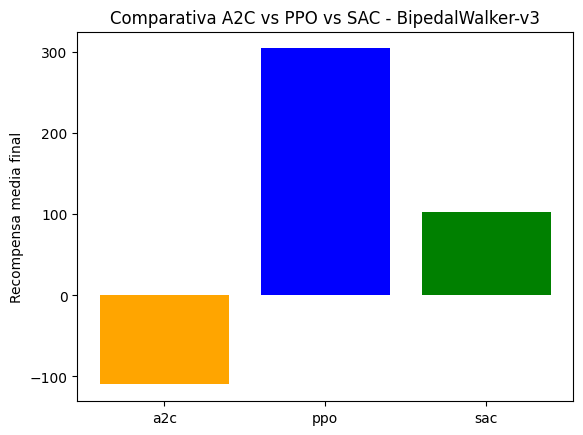

In [ ]:
def get_mean_reward(alg_name):
    eval_file = f"./logs/{alg_name}/evaluations.npz"
    if os.path.exists(eval_file):
        data = np.load(eval_file)
        results = data["results"]  # matriz [n_evals, n_episodios]
        return results.mean(axis=1)[-1]  # promedio del último bloque de evaluaciones
    else:
        print(f"⚠️ No se encontró evaluations.npz para {alg_name}")
        return np.nan

# === Comparar los tres algoritmos ===
algos = ["a2c", "ppo", "sac"]
means = [get_mean_reward(a) for a in algos]

plt.bar(algos, means, color=["orange", "blue", "green"])
plt.ylabel("Recompensa media final")
plt.title("Comparativa A2C vs PPO vs SAC - BipedalWalker-v3")
plt.show()


In [ ]:
from gymnasium.wrappers import RecordVideo
from IPython.display import Video, display

# ===============================
# FUNCIÓN GENERAL PARA GRABAR VIDEO
# ===============================
def grabar_video(model_path, alg, video_folder, prefix, steps=2000):
    os.makedirs(video_folder, exist_ok=True)

    # Crear entorno normal con render_mode
    env = gym.make("BipedalWalker-v3", render_mode="rgb_array")
    env = RecordVideo(env, video_folder=video_folder, name_prefix=prefix)

    # Cargar modelo
    model = alg.load(model_path)

    obs, _ = env.reset()
    total_reward = 0.0
    for _ in range(steps):
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, done, truncated, info = env.step(action)
        total_reward += reward
        if done or truncated:
            obs, _ = env.reset()
    env.close()

    # Buscar último video generado
    videos = sorted(os.listdir(video_folder))
    last_video = [v for v in videos if v.endswith(".mp4")][-1]
    video_path = os.path.join(video_folder, last_video)
    print(f"🎞️ Video guardado en: {video_path}")
    print(f"🏅 Recompensa total del episodio: {total_reward:.2f}")

    # Mostrar inline en notebook
    display(Video(video_path, embed=True))

# ===============================
# GENERAR VIDEOS PARA LOS TRES MODELOS
# ===============================

# --- A2C ---
grabar_video(
    model_path="./models/a2c/best_model.zip",
    alg=A2C,
    video_folder="./videos/a2c/",
    prefix="a2c_bipedal",
)

# --- PPO ---
grabar_video(
    model_path="./models/ppo/best_model.zip",
    alg=PPO,
    video_folder="./videos/ppo/",
    prefix="ppo_bipedal",
)

# --- SAC ---
grabar_video(
    model_path="./models/sac/best_model.zip",
    alg=SAC,
    video_folder="./videos/sac/",
    prefix="sac_bipedal",
)


/home/agustin/Desktop/CEIA UBA/Aprendizaje por Refuerzo II/CEIA-AprendizajeRefuerzoII/.venv/lib/python3.12/site-packages/gymnasium/wrappers/rendering.py:293: UserWarning: WARN: Overwriting existing videos at /home/agustin/Desktop/CEIA UBA/Aprendizaje por Refuerzo II/CEIA-AprendizajeRefuerzoII/videos/a2c folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
/home/agustin/Desktop/CEIA UBA/Aprendizaje por Refuerzo II/CEIA-AprendizajeRefuerzoII/.venv/lib/python3.12/site-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run A2C on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization w

🎞️ Video guardado en: ./videos/a2c/a2c_bipedal-episode-8.mp4
🏅 Recompensa total del episodio: -2261.51


/home/agustin/Desktop/CEIA UBA/Aprendizaje por Refuerzo II/CEIA-AprendizajeRefuerzoII/.venv/lib/python3.12/site-packages/gymnasium/wrappers/rendering.py:293: UserWarning: WARN: Overwriting existing videos at /home/agustin/Desktop/CEIA UBA/Aprendizaje por Refuerzo II/CEIA-AprendizajeRefuerzoII/videos/ppo folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
/home/agustin/Desktop/CEIA UBA/Aprendizaje por Refuerzo II/CEIA-AprendizajeRefuerzoII/.venv/lib/python3.12/site-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization w

🎞️ Video guardado en: ./videos/ppo/ppo_bipedal-episode-8.mp4
🏅 Recompensa total del episodio: -1881.03


/home/agustin/Desktop/CEIA UBA/Aprendizaje por Refuerzo II/CEIA-AprendizajeRefuerzoII/.venv/lib/python3.12/site-packages/gymnasium/wrappers/rendering.py:293: UserWarning: WARN: Overwriting existing videos at /home/agustin/Desktop/CEIA UBA/Aprendizaje por Refuerzo II/CEIA-AprendizajeRefuerzoII/videos/sac folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


🎞️ Video guardado en: ./videos/sac/sac_bipedal-episode-1.mp4
🏅 Recompensa total del episodio: -213.98
